# Predict tags on StackOverflow with linear models

### Data



### Text preprocessing

For this and most of the following assignments you will need to use a list of stop words. It can be downloaded from *nltk*:

In [1]:
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords

[nltk_data] Downloading package stopwords to
[nltk_data]     /home/mohamed/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [2]:
from ast import literal_eval
import pandas as pd
import numpy as np

In [3]:
def read_data(filename):
    data = pd.read_csv(filename, sep='\t')
    data['tags'] = data['tags'].apply(literal_eval)
    return data

In [4]:
train = read_data('data/train.tsv')
validation = read_data('data/validation.tsv')
test = pd.read_csv('data/test.tsv', sep='\t')

In [5]:
train.head()

,title,tags
0,How to draw a stacked dotplot in R?,[r]
1,mysql select all records where a datetime fiel...,"[php, mysql]"
2,How to terminate windows phone 8.1 app,[c#]
3,get current time in a specific country via jquery,"[javascript, jquery]"
4,Configuring Tomcat to Use SSL,[java]


For a more comfortable usage, initialize *X_train*, *X_val*, *X_test*, *y_train*, *y_val*.

In [12]:
X_train, y_train = train['title'].values, train['tags'].values
X_val, y_val = validation['title'].values, validation['tags'].values
X_test = test['title'].values

In [6]:
import re

In [7]:
REPLACE_BY_SPACE_RE = re.compile('[/(){}\[\]\|@,;]')
BAD_SYMBOLS_RE = re.compile('[^0-9a-z #+_]')
STOPWORDS = set(stopwords.words('english'))

def text_prepare(text):
    """
        text: a string
        
        return: modified initial string
    """
    text = text.lower()# lowercase text
    text = re.sub(REPLACE_BY_SPACE_RE,"",text)# replace REPLACE_BY_SPACE_RE symbols by space in text
    text = re.sub(BAD_SYMBOLS_RE,"",text) # delete symbols which are in BAD_SYMBOLS_RE from text
    text = " ".join(w for w in text.split() if w not in STOPWORDS)# delete stopwords from text
    return text

In [8]:
def test_text_prepare():
    examples = ["SQL Server - any equivalent of Excel's CHOOSE function?",
                "How to free c++ memory vector<int> * arr?"]
    answers = ["sql server equivalent excels choose function", 
               "free c++ memory vectorint arr"]
    for ex, ans in zip(examples, answers):
        if text_prepare(ex) != ans:
            return "Wrong answer for the case: '%s'" % ex
    return 'Basic tests are passed.'

In [9]:
print(test_text_prepare())

Basic tests are passed.


In [10]:
prepared_questions = []
for line in open('data/text_prepare_tests.tsv', encoding='utf-8'):
    line = text_prepare(line.strip())
    prepared_questions.append(line)
text_prepare_results = '\n'.join(prepared_questions)

text_prepare_results

'sqlitephp readonly\ncreating multiple textboxes dynamically\nself one prefer javascript\nsave php date string mysql database timestamp\nfill dropdownlist data xml file aspnet application\nprogrammatically trigger jqueryui draggables drag event\nget value method argument via reflection java\nknockout mapingfromjs observablearray json object data gets lost\nfacebook connect localhost weird stuff\nfullcalendar prev next click\nsyntaxerror unexpected token\neffective way float double comparison\ngem install rails fails dns error\nlistshuttle component richfaces getting updated\nlaravel responsedownload show images laravel\nwrong rspec test\ncalendar display using java swing\npython selenium import regular firefox profile addons\nrandom number 2 variablesvalues\naltering http responses firefox extension\nstart session python web application\nalign radio buttons horizontally django forms\ncount number rows sqlite database\nwordpress wp_rewrite rules\nremoving sheet excel 2005 using php\nphp

Now we can preprocess the titles using function *text_prepare* and  making sure that the headers don't have bad symbols:

In [13]:
X_train = [text_prepare(x) for x in X_train]
X_val = [text_prepare(x) for x in X_val]
X_test = [text_prepare(x) for x in X_test]

In [14]:
X_train[:3]

['draw stacked dotplot r',
 'mysql select records datetime field less specified value',
 'terminate windows phone 81 app']

In [15]:
# Dictionary of all tags from train corpus with their counts.
tags_counts = {}
# Dictionary of all words from train corpus with their counts.
words_counts = {}

for tags,text in zip(y_train,X_train) :
    for tag in tags :
        if tag in tags_counts :
            tags_counts[tag] += 1 
        else :
            tags_counts[tag] =1
    for word in text.split():
        if word in words_counts :
            words_counts[word] += 1
        else :
            words_counts[word]=1
    

In [17]:
most_common_tags = sorted(tags_counts.items(), key=lambda x: x[1], reverse=True)[:3]
most_common_words = sorted(words_counts.items(), key=lambda x: x[1], reverse=True)[:3]


In [18]:
most_common_tags

[('javascript', 19078), ('c#', 19077), ('java', 18661)]

In [21]:
DICT_SIZE = 5000
most_common_tags = sorted(tags_counts.items(), key=lambda x: x[1], reverse=True)[:DICT_SIZE]
most_common_words = sorted(words_counts.items(), key=lambda x: x[1], reverse=True)[:DICT_SIZE]
WORDS_TO_INDEX ={i[0]:j for j,i in enumerate(most_common_words)} ####### YOUR CODE HERE #######
INDEX_TO_WORDS = {i:j for j,i in WORDS_TO_INDEX.items()}####### YOUR CODE HERE #######
ALL_WORDS = WORDS_TO_INDEX.keys()

def my_bag_of_words(text, words_to_index, dict_size):
    """
        text: a string
        dict_size: size of the dictionary
        
        return a vector which is a bag-of-words representation of 'text'
    """
    
    result_vector = np.zeros(dict_size)
    
    for t in text.split():
        if t in words_to_index :
            index = words_to_index[t]
            result_vector[index]+=1
    return result_vector

In [22]:
def test_my_bag_of_words():
    words_to_index = {'hi': 0, 'you': 1, 'me': 2, 'are': 3}
    examples = ['hi how are you']
    answers = [[1, 1, 0, 1]]
    for ex, ans in zip(examples, answers):
        if (my_bag_of_words(ex, words_to_index, 4) != ans).any():
            return "Wrong answer for the case: '%s'" % ex
    return 'Basic tests are passed.'

In [23]:
print(test_my_bag_of_words())

Basic tests are passed.


In [24]:
len(WORDS_TO_INDEX)

5000

Now apply the implemented function to all samples (this might take up to a minute):

In [25]:
from scipy import sparse as sp_sparse

In [26]:
X_train_mybag = sp_sparse.vstack([sp_sparse.csr_matrix(my_bag_of_words(text, WORDS_TO_INDEX, DICT_SIZE)) for text in X_train])
X_val_mybag = sp_sparse.vstack([sp_sparse.csr_matrix(my_bag_of_words(text, WORDS_TO_INDEX, DICT_SIZE)) for text in X_val])
X_test_mybag = sp_sparse.vstack([sp_sparse.csr_matrix(my_bag_of_words(text, WORDS_TO_INDEX, DICT_SIZE)) for text in X_test])
print('X_train shape ', X_train_mybag.shape)
print('X_val shape ', X_val_mybag.shape)
print('X_test shape ', X_test_mybag.shape)

X_train shape  (100000, 5000)
X_val shape  (30000, 5000)
X_test shape  (20000, 5000)


In [27]:
row = X_train_mybag[10].toarray()[0]
non_zero_elements_count = len(row[row != 0]) 



In [28]:
from sklearn.feature_extraction.text import TfidfVectorizer

In [30]:
def tfidf_features(X_train, X_val, X_test):
    """
        X_train, X_val, X_test — samples        
        return TF-IDF vectorized representation of each sample and vocabulary
    """
   
    
    
    tfidf_vectorizer = TfidfVectorizer(min_df=5,max_df=0.9,token_pattern= '(\S+)')
    
   
    X_train = tfidf_vectorizer.fit_transform(X_train)
    X_test = tfidf_vectorizer.transform(X_test)
    X_val = tfidf_vectorizer.transform(X_val)
    
    return X_train, X_val, X_test, tfidf_vectorizer.vocabulary_

In [31]:
X_train_tfidf, X_val_tfidf, X_test_tfidf, tfidf_vocab = tfidf_features(X_train, X_val, X_test)
tfidf_reversed_vocab = {i:word for word,i in tfidf_vocab.items()}

In [30]:
print(X_val_mybag.shape)
print(X_train_tfidf.shape)


(30000, 5000)
(100000, 6292)


### MultiLabel classifier

As we have noticed before, in this task each example can have multiple tags. To deal with such kind of prediction, we need to transform labels in a binary form and the prediction will be a mask of 0s and 1s. For this purpose it is convenient to use [MultiLabelBinarizer](http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.MultiLabelBinarizer.html) from *sklearn*.

In [32]:
from sklearn.preprocessing import MultiLabelBinarizer

In [33]:
mlb = MultiLabelBinarizer(classes=sorted(tags_counts.keys()))
y_train = mlb.fit_transform(y_train)
y_val = mlb.fit_transform(y_val)

In [34]:
from sklearn.multiclass import OneVsRestClassifier
from sklearn.linear_model import LogisticRegression, RidgeClassifier

In [35]:
def train_classifier(X_train, y_train,C=1,penalty="l2"):
    """
      X_train, y_train — training data
      
      return: trained classifier
    """
    
     
    lr = LogisticRegression(solver='newton-cg',C=C, penalty=penalty,n_jobs=-1)
    # lr.fit(X_train, y_train)
    ovr = OneVsRestClassifier(lr)
    ovr.fit(X_train, y_train)
    return ovr

Train the classifiers for different data transformations: *bag-of-words* and *tf-idf*.

In [36]:
classifier_mybag = train_classifier(X_train_mybag, y_train)
classifier_tfidf = train_classifier(X_train_tfidf, y_train)

In [37]:
y_val_predicted_labels_mybag = classifier_mybag.predict(X_val_mybag)
y_val_predicted_scores_mybag = classifier_mybag.decision_function(X_val_mybag)

y_val_predicted_labels_tfidf = classifier_tfidf.predict(X_val_tfidf)
y_val_predicted_scores_tfidf = classifier_tfidf.decision_function(X_val_tfidf)

In [38]:
y_val_pred_inversed = mlb.inverse_transform(y_val_predicted_labels_tfidf)
y_val_inversed = mlb.inverse_transform(y_val)
for i in range(3):
    print('Title:\t{}\nTrue labels:\t{}\nPredicted labels:\t{}\n\n'.format(
        X_val[i],
        ','.join(y_val_inversed[i]),
        ','.join(y_val_pred_inversed[i])
    ))

Title:	odbc_exec always fail
True labels:	php,sql
Predicted labels:	


Title:	access base classes variable within child class
True labels:	javascript
Predicted labels:	


Title:	contenttype applicationjson required rails
True labels:	ruby,ruby-on-rails
Predicted labels:	ruby-on-rails




### Evaluation

To evaluate the results we will use several classification metrics:
 - [Accuracy](http://scikit-learn.org/stable/modules/generated/sklearn.metrics.accuracy_score.html)
 - [F1-score](http://scikit-learn.org/stable/modules/generated/sklearn.metrics.f1_score.html)
 - [Area under ROC-curve](http://scikit-learn.org/stable/modules/generated/sklearn.metrics.roc_auc_score.html)
 - [Area under precision-recall curve](http://scikit-learn.org/stable/modules/generated/sklearn.metrics.average_precision_score.html#sklearn.metrics.average_precision_score) 
 


In [39]:
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score
from sklearn.metrics import roc_auc_score 
from sklearn.metrics import average_precision_score
from sklearn.metrics import recall_score

In [41]:
def print_evaluation_scores(y_val, predicted):
    
   
    print("accuracy: ",accuracy_score(y_val, predicted))
    print("f1 :",f1_score(y_val, predicted,average="weighted"))
    print("precision :",average_precision_score(y_val, predicted,average="weighted"))
    
def avg_jacard(y_true,y_pred):
    
    jacard = np.minimum(y_true,y_pred).sum(axis=1) / np.maximum(y_true,y_pred).sum(axis=1)
    
    return jacard.mean()*100

def print_score(y_pred, y_test):
    print("Jacard score: {}".format(avg_jacard(y_test, y_pred)))
    print("---")    

In [42]:
print('Bag-of-words')
print_evaluation_scores(y_val, y_val_predicted_labels_mybag)
print('Tfidf')
print_evaluation_scores(y_val, y_val_predicted_labels_tfidf)
print_score(y_val, y_val_predicted_labels_tfidf)


Bag-of-words
accuracy:  0.3537
f1 : 0.6434029021830375
precision : 0.5049253814376315
Tfidf
accuracy:  0.3330666666666667
f1 : 0.6129281180749
precision : 0.48200601739883786
Jacard score: 51.43494444444444
---


In [100]:
from metrics import roc_auc
%matplotlib inline

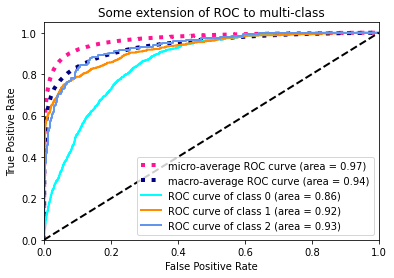

In [101]:
n_classes = len(tags_counts)
roc_auc(y_val, y_val_predicted_scores_mybag, n_classes)

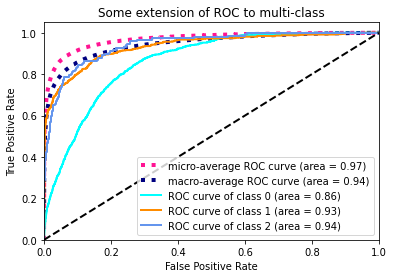

In [102]:
n_classes = len(tags_counts)
roc_auc(y_val, y_val_predicted_scores_tfidf, n_classes)

### Analysis of the most important features

In [43]:
def print_words_for_tag(classifier, tag, tags_classes, index_to_words, all_words):
   
    
    print('Tag:\t{}'.format(tag))
    est = classifier.estimators_[tags_classes.index(tag)]
    top_positive_words = [index_to_words[index] for index in est.coef_.argsort().tolist()[0][-5:]]  # top-5 words sorted by the coefficiens.
    top_negative_words = [index_to_words[index] for index in est.coef_.argsort().tolist()[0][:5]] # bottom-5 words  sorted by the coefficients.
    print('Top positive words:\t{}'.format(', '.join(top_positive_words)))
    print('Top negative words:\t{}\n'.format(', '.join(top_negative_words)))

In [44]:
print_words_for_tag(classifier_tfidf, 'c', mlb.classes, tfidf_reversed_vocab, ALL_WORDS)
print_words_for_tag(classifier_tfidf, 'c++', mlb.classes, tfidf_reversed_vocab, ALL_WORDS)
print_words_for_tag(classifier_tfidf, 'python', mlb.classes, tfidf_reversed_vocab, ALL_WORDS)

Tag:	c
Top positive words:	gcc, malloc, scanf, cc++, c
Top negative words:	objective, java, php, python, javascript

Tag:	c++
Top positive words:	mfc, boost, cc++, qt, c++
Top negative words:	java, php, python, javascript, c#

Tag:	python
Top positive words:	sqlalchemy, matplotlib, pandas, numpy, python
Top negative words:	php, java, c#, javascript, jquery

